In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [4]:
# Data Preparation
train_dir = "../../data4/train"
validation_dir = "../../data4/validation"
batch_size = 32
image_size = (224, 224)

# Reduced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,  # Reduced rotation
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,  # Reduced shifts
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = train_generator.num_classes

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.


In [22]:
# Standalone ResNet50 Model
def build_resnet50_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet_base.trainable = False  # Freeze base model

    input_tensor = Input(shape=(224, 224, 3))
    x = resnet_base(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_resnet50_model(num_classes)

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=1000, alpha=0.00001
)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

In [23]:
# Train the ResNet50 Model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
model.save("../../models/Improved_resnet50_model.keras")

Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - AUC: 0.6826 - accuracy: 0.4175 - loss: 1.2953 - val_AUC: 0.6575 - val_accuracy: 0.3983 - val_loss: 1.3459 - learning_rate: 9.1530e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - AUC: 0.7769 - accuracy: 0.5223 - loss: 1.1075 - val_AUC: 0.7759 - val_accuracy: 0.5120 - val_loss: 1.2358 - learning_rate: 6.8989e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - AUC: 0.8064 - accuracy: 0.5521 - loss: 1.0451 - val_AUC: 0.8195 - val_accuracy: 0.5754 - val_loss: 1.0538 - learning_rate: 4.0015e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - AUC: 0.8245 - accuracy: 0.5703 - loss: 0.9943 - val_AUC: 0.8474 - val_accuracy: 0.6100 - val_loss: 0.9461 - learning_rate: 1.4424e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - AUC: 0.8272 - accuracy: 0.5876 - loss: 0.9877 - val_AUC: 0.8499 - val_accuracy: 0.6154 - val_loss: 0.9294 - learning_rate: 8.8663e-06
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - AUC: 0.8267

53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 949ms/step - AUC: 0.8445 - accuracy: 0.6251 - loss: 0.9548
Validation Loss: 0.93
Validation Accuracy: 0.62
53/53 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.27      0.31      0.29       450
      2. Ekzama       0.27      0.30      0.29       450
        3. Akne       0.17      0.14      0.15       322
      4. Malign       0.26      0.22      0.23       450

       accuracy                           0.25      1672
      macro avg       0.24      0.24      0.24      1672
   weighted avg       0.25      0.25      0.25      1672

[[138 137  75 100]
 [114 137  91 108]
 [109  94  46  73]
 [154 135  64  97]]


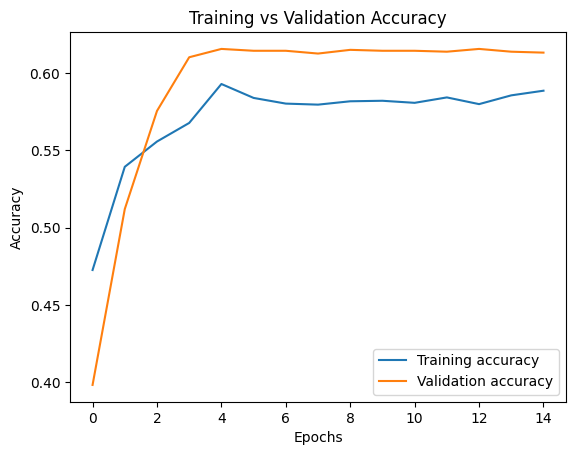

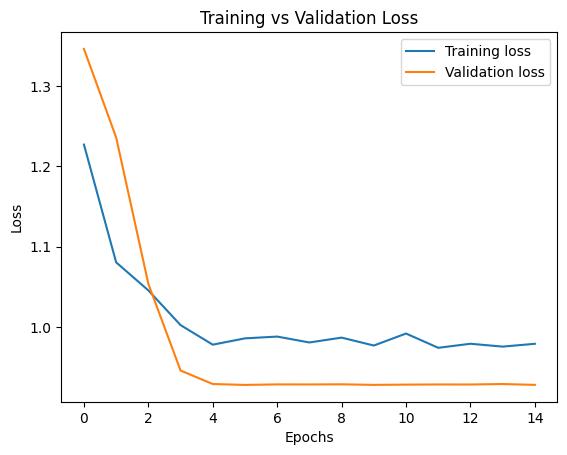

In [24]:
# Evaluate the ResNet50 Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")

# Classification report and confusion matrix
val_preds = np.argmax(model.predict(validation_generator), axis=1)
true_labels = validation_generator.classes
print(classification_report(true_labels, val_preds, target_names=validation_generator.class_indices.keys()))
print(confusion_matrix(true_labels, val_preds))

# Plot training and validation curves
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1160s 6s/step - AUC: 0.5343 - accuracy: 0.2665 - loss: 1.3768 - val_AUC: 0.4647 - val_accuracy: 0.2159 - val_loss: 1.4028 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1126s 6s/step - AUC: 0.6867 - accuracy: 0.4064 - loss: 1.2825 - val_AUC: 0.4583 - val_accuracy: 0.2039 - val_loss: 1.4161 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1129s 6s/step - AUC: 0.6995 - accuracy: 0.4070 - loss: 1.2399 - val_AUC: 0.5813 - val_accuracy: 0.2841 - val_loss: 1.3814 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1124s 6s/step - AUC: 0.6946 - accuracy: 0.4103 - loss: 1.2312 - val_AUC: 0.6930 - val_accuracy: 0.4085 - val_loss: 1.2756 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1125s 6s/step - AUC: 0.7219 - accuracy: 0.4336 - loss: 1.1855 - val_AUC: 0.8220 - val_accuracy: 0.5730 - val_loss: 1.1383 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1138s 6s/s

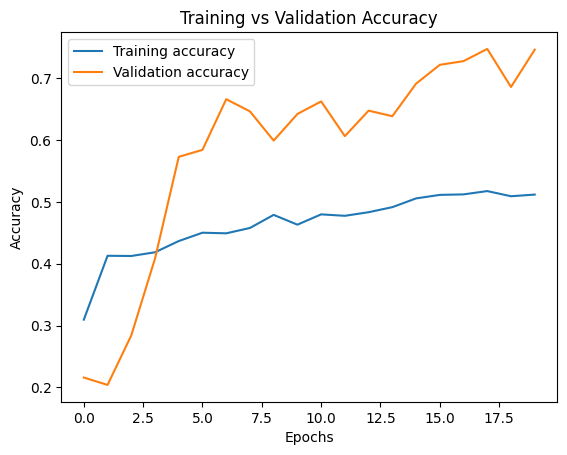

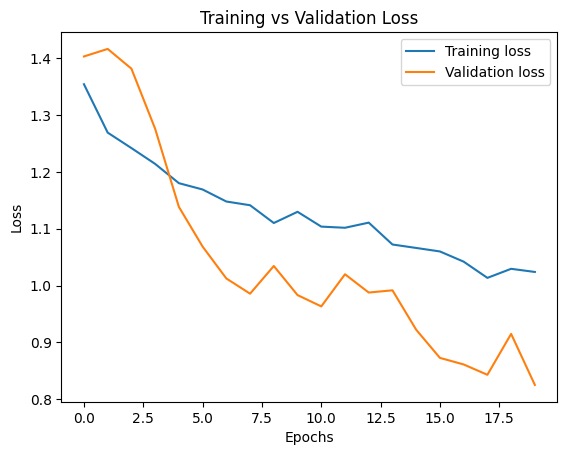

In [28]:
# Unfreeze the last few layers of the original model
for layer in model.layers[-10:]:
    layer.trainable = True  # Enable training for the last 10 layers

# Add dropout layers to the fully connected part of the model
x = model.output
x = Dropout(0.5)(x)  # Add dropout before the final dense layers
x = Dense(256, activation='relu')(x)  # Add an extra dense layer for better representation
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(num_classes, activation='softmax')(x)  # Final output layer

# Create a new model
dropout_model = Model(inputs=model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
dropout_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'AUC']
)

# Fine-tune the model
fine_tune_history = dropout_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Save the fine-tuned model
dropout_model.save("../../models/Improved_resnet50_model.keras")

# Plot training results
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(fine_tune_history, metrics=["accuracy", "loss"])

In [26]:
# Evaluate the ResNet50 Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 53s 997ms/step - AUC: 0.8440 - accuracy: 0.6092 - loss: 0.9396
Validation Loss: 0.93
Validation Accuracy: 0.62


In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have `validation_generator` and the model
# Generate predictions
y_true = validation_generator.classes
y_pred = dropout_model.predict(validation_generator)

# Binarize the true labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']  # Use distinct colors for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f"Class {i + 1} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=2)

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


NameError: name 'dropout_model' is not defined